# Cycling Performance Analysis

This notebook analyzes cycling performance data from a GPX file. The analysis includes:
1. Heart rate over time visualization
2. Route visualization on a map

The data is loaded from the file 'Morning_Ride.gpx'.

In [6]:
# Import required libraries
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
from datetime import datetime
import seaborn as sns

# Set the style for plots
plt.style.use('ggplot')
sns.set(style="whitegrid")

In [7]:
# Load and parse the GPX file
gpx_file_path = 'Morning_Ride.gpx'

try:
    with open(gpx_file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    
    print(f"GPX file loaded successfully!")
    print(f"Number of tracks: {len(gpx.tracks)}")
    print(f"Number of segments: {len(gpx.tracks[0].segments)}")
    print(f"Number of points: {len(gpx.tracks[0].segments[0].points)}")
except Exception as e:
    print(f"Error loading GPX file: {e}")

GPX file loaded successfully!
Number of tracks: 1
Number of segments: 1
Number of points: 7918


In [8]:
# Extract data from GPX file (time, latitude, longitude, and heart rate)
data = []

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            heart_rate = None
            
            # Extract heart rate from extensions if available
            for ext in point.extensions:
                for child in ext:
                    if 'hr' in child.tag:
                        try:
                            heart_rate = int(child.text)
                        except (ValueError, TypeError):
                            pass
            
            # Add data point to list
            data.append({
                'time': point.time,
                'latitude': point.latitude,
                'longitude': point.longitude,
                'elevation': point.elevation,
                'heart_rate': heart_rate
            })

# Create DataFrame from extracted data
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

time   latitude   longitude  elevation  heart_rate
0 2024-12-01 18:05:07+00:00  47.579221 -122.000199      128.3         136
1 2024-12-01 18:05:08+00:00  47.579163 -122.000361      128.4         136
2 2024-12-01 18:05:09+00:00  47.579192 -122.000404      128.5         136
3 2024-12-01 18:05:10+00:00  47.579220 -122.000462      128.5         136
4 2024-12-01 18:05:11+00:00  47.579246 -122.000518      128.5         136

In [9]:
# Clean and prepare the data for visualization
# Convert time to datetime if it's not already
if not pd.api.types.is_datetime64_any_dtype(df['time']):
    df['time'] = pd.to_datetime(df['time'])

# Check for missing heart rate values
missing_hr = df['heart_rate'].isna().sum()
print(f"Number of data points with missing heart rate: {missing_hr} ({missing_hr/len(df)*100:.2f}%)")

# Remove rows with missing heart rate if necessary
if missing_hr > 0:
    df = df.dropna(subset=['heart_rate'])
    print(f"DataFrame after removing missing heart rate values: {len(df)} rows")

# Add a relative time column (minutes from start)
df['minutes'] = (df['time'] - df['time'].min()).dt.total_seconds() / 60

# Display basic statistics about heart rate
hr_stats = df['heart_rate'].describe()
print("\nHeart Rate Statistics:")
print(hr_stats)

Number of data points with missing heart rate: 0 (0.00%)

Heart Rate Statistics:
count    7918.000000
mean      137.586891
std         8.458995
min       115.000000
25%       133.000000
50%       133.000000
75%       138.000000
max       166.000000
Name: heart_rate, dtype: float64


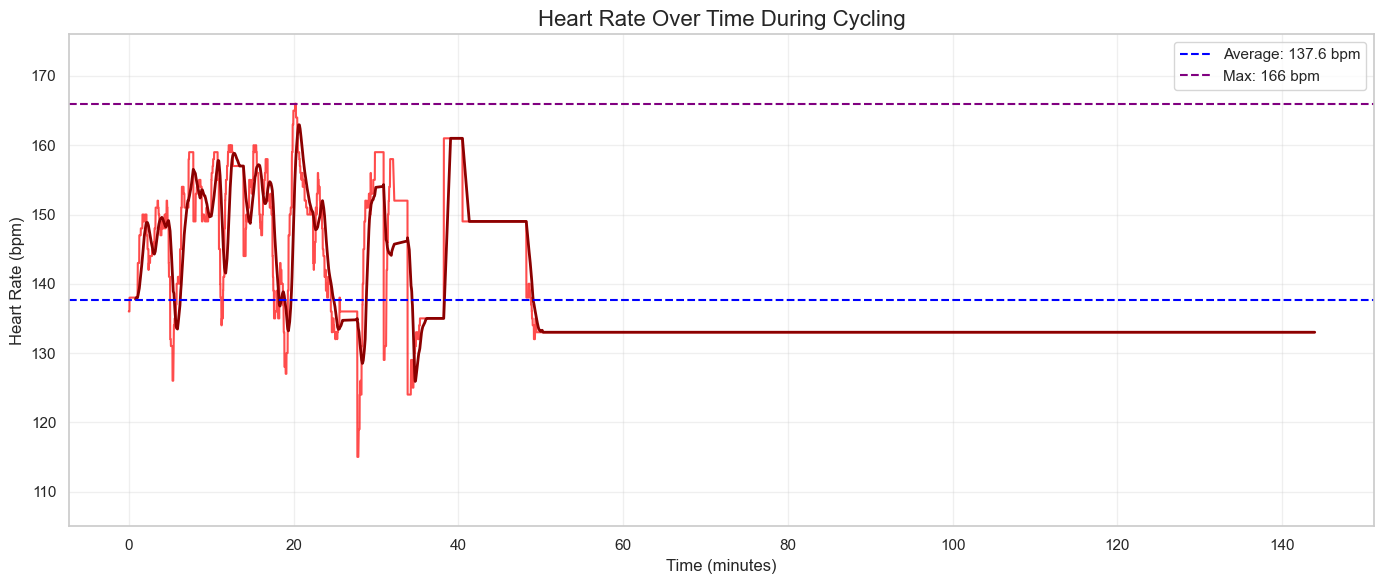

In [10]:
# Visualize heart rate over time
plt.figure(figsize=(14, 6))

# Plot heart rate over time
plt.plot(df['minutes'], df['heart_rate'], color='red', alpha=0.7)

# Add a smoothed line to show the trend
window_size = 50
df['heart_rate_smooth'] = df['heart_rate'].rolling(window=window_size).mean()
plt.plot(df['minutes'], df['heart_rate_smooth'], color='darkred', linewidth=2)

# Add horizontal lines for different heart rate zones
plt.axhline(y=df['heart_rate'].mean(), color='blue', linestyle='--', label=f'Average: {df["heart_rate"].mean():.1f} bpm')
plt.axhline(y=df['heart_rate'].max(), color='purple', linestyle='--', label=f'Max: {df["heart_rate"].max()} bpm')

# Add labels and title
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Heart Rate (bpm)', fontsize=12)
plt.title('Heart Rate Over Time During Cycling', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

# Add some padding to the y-axis
y_min = max(100, df['heart_rate'].min() - 10)
y_max = df['heart_rate'].max() + 10
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()

## Route Visualization

Below we'll create an interactive map showing the route of the ride with color-coded segments based on heart rate intensity.

In [11]:
# Create a map visualization of the route
# Get the starting coordinates for the map center
start_coords = (df['latitude'].iloc[0], df['longitude'].iloc[0])

# Create the map
route_map = folium.Map(location=start_coords, zoom_start=13)

# Prepare the route points
route = list(zip(df['latitude'], df['longitude'], df['heart_rate']))

# Define a color function based on heart rate
def get_color(heart_rate):
    # Define heart rate zones (adjust based on your fitness level if needed)
    if heart_rate < 130:  # Easy/recovery
        return 'green'
    elif heart_rate < 140:  # Aerobic/endurance
        return 'blue'
    elif heart_rate < 150:  # Tempo
        return 'orange'
    elif heart_rate < 160:  # Threshold
        return 'red'
    else:  # Anaerobic/VO2 max
        return 'darkred'

# Add a marker for the start point
folium.Marker(
    location=start_coords,
    popup="Start",
    icon=folium.Icon(color="green", icon="play"),
).add_to(route_map)

# Add a marker for the end point
end_coords = (df['latitude'].iloc[-1], df['longitude'].iloc[-1])
folium.Marker(
    location=end_coords,
    popup="Finish",
    icon=folium.Icon(color="red", icon="stop"),
).add_to(route_map)

# Add color-coded line segments based on heart rate
for i in range(len(route) - 1):
    # Get current segment points
    point1 = route[i]
    point2 = route[i + 1]
    
    # Only plot every 5th point to improve performance and reduce visual clutter
    if i % 5 == 0:
        # Get color based on heart rate
        color = get_color(point1[2])
        
        # Add line segment to map
        folium.PolyLine(
            locations=[(point1[0], point1[1]), (point2[0], point2[1])],
            color=color,
            weight=4,
            opacity=0.8
        ).add_to(route_map)

# Display the map
route_map

## Speed Analysis

Next, we'll calculate and visualize the cyclist's speed throughout the ride. This helps identify:
- Variations in pace throughout the ride
- Maximum and average speeds
- When the cyclist was accelerating or decelerating

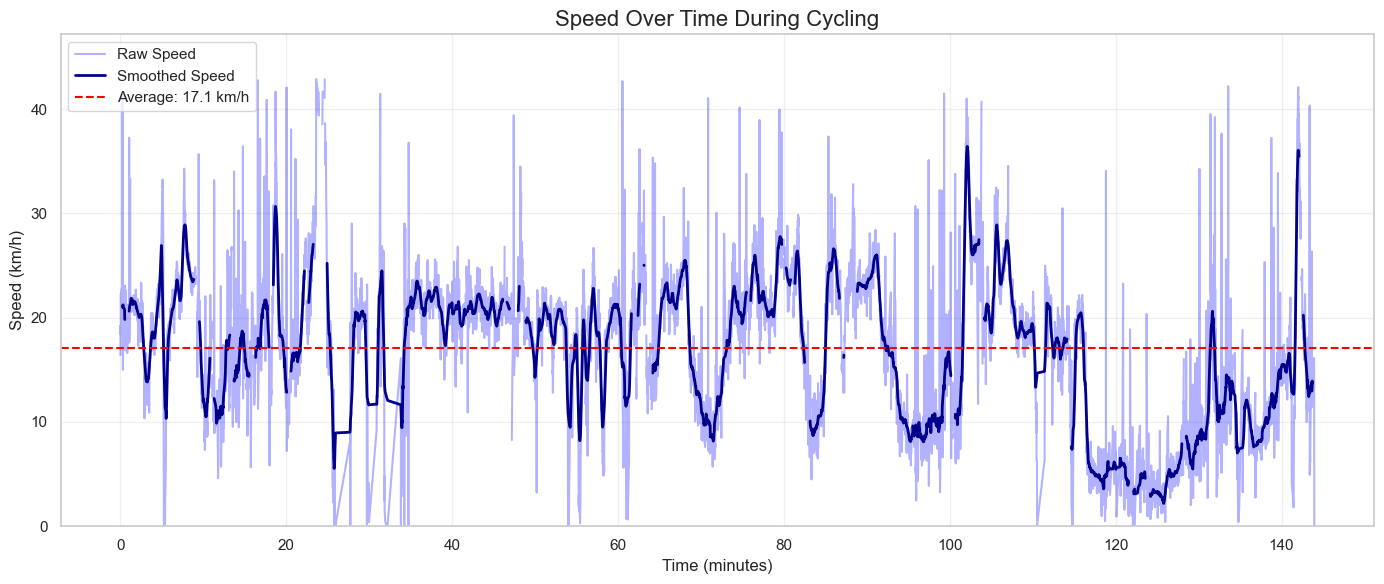

Maximum speed: 42.9 km/h
Average speed: 17.1 km/h
Total distance: 39.81 km
Total duration: 143.9 minutes


In [12]:
# Calculate speed between consecutive points
df['next_lat'] = df['latitude'].shift(-1)
df['next_lon'] = df['longitude'].shift(-1)
df['next_time'] = df['time'].shift(-1)

# Function to calculate distance between two points using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the distance between two points using Haversine formula"""
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r * 1000  # Convert to meters

# Apply the function to calculate distance between consecutive points
df['distance'] = df.apply(
    lambda row: haversine_distance(
        row['latitude'], row['longitude'], 
        row['next_lat'], row['next_lon']
    ) if not pd.isna(row['next_lat']) else 0,
    axis=1
)

# Calculate time difference in seconds
df['time_diff'] = (df['next_time'] - df['time']).dt.total_seconds()

# Calculate speed in meters per second and convert to km/h
df['speed_mps'] = df.apply(
    lambda row: row['distance'] / row['time_diff'] if row['time_diff'] > 0 else 0,
    axis=1
)
df['speed_kmh'] = df['speed_mps'] * 3.6  # Convert m/s to km/h

# Remove potential outliers (extremely high speeds due to GPS errors)
speed_threshold = df['speed_kmh'].quantile(0.99)  # 99th percentile
df.loc[df['speed_kmh'] > speed_threshold, 'speed_kmh'] = np.nan

# Smooth the speed data
df['speed_smooth'] = df['speed_kmh'].rolling(window=30, center=True).mean()

# Visualize speed over time
plt.figure(figsize=(14, 6))

# Plot raw speed data with low opacity
plt.plot(df['minutes'], df['speed_kmh'], color='blue', alpha=0.3, label='Raw Speed')

# Plot smoothed speed
plt.plot(df['minutes'], df['speed_smooth'], color='darkblue', linewidth=2, label='Smoothed Speed')

# Add horizontal line for average speed
avg_speed = df['speed_kmh'].mean()
plt.axhline(y=avg_speed, color='red', linestyle='--', 
            label=f'Average: {avg_speed:.1f} km/h')

# Add labels and title
plt.xlabel('Time (minutes)', fontsize=12)
plt.ylabel('Speed (km/h)', fontsize=12)
plt.title('Speed Over Time During Cycling', fontsize=16)
plt.grid(True, alpha=0.3)
plt.legend()

# Set y-axis limits
plt.ylim(0, min(60, df['speed_kmh'].max() * 1.1))  # Cap at 60 km/h for better visualization

plt.tight_layout()
plt.show()

# Print some speed statistics
print(f"Maximum speed: {df['speed_kmh'].max():.1f} km/h")
print(f"Average speed: {avg_speed:.1f} km/h")
print(f"Total distance: {df['distance'].sum()/1000:.2f} km")
print(f"Total duration: {df['minutes'].max():.1f} minutes")

## Elevation Profile

The elevation profile shows the terrain of the ride, highlighting climbs and descents. We'll visualize:
- Elevation changes throughout the ride
- Correlation between heart rate and elevation (climbing effort)
- Grade percentage for significant climbs

C:\Users\milively\AppData\Local\Temp\ipykernel_35440\1177158339.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['elevation_diff'].fillna(0, inplace=True)
C:\Users\milively\AppData\Local\Temp\ipykernel_35440\1177158339.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['cumulative_climb'] = df.loc[df['elevation_diff'] > 0, 'elevation_diff'].cumsum().fillna(method='ffill')
C:\Users\milively\AppData\Local\Temp\ipykernel_35440\11771

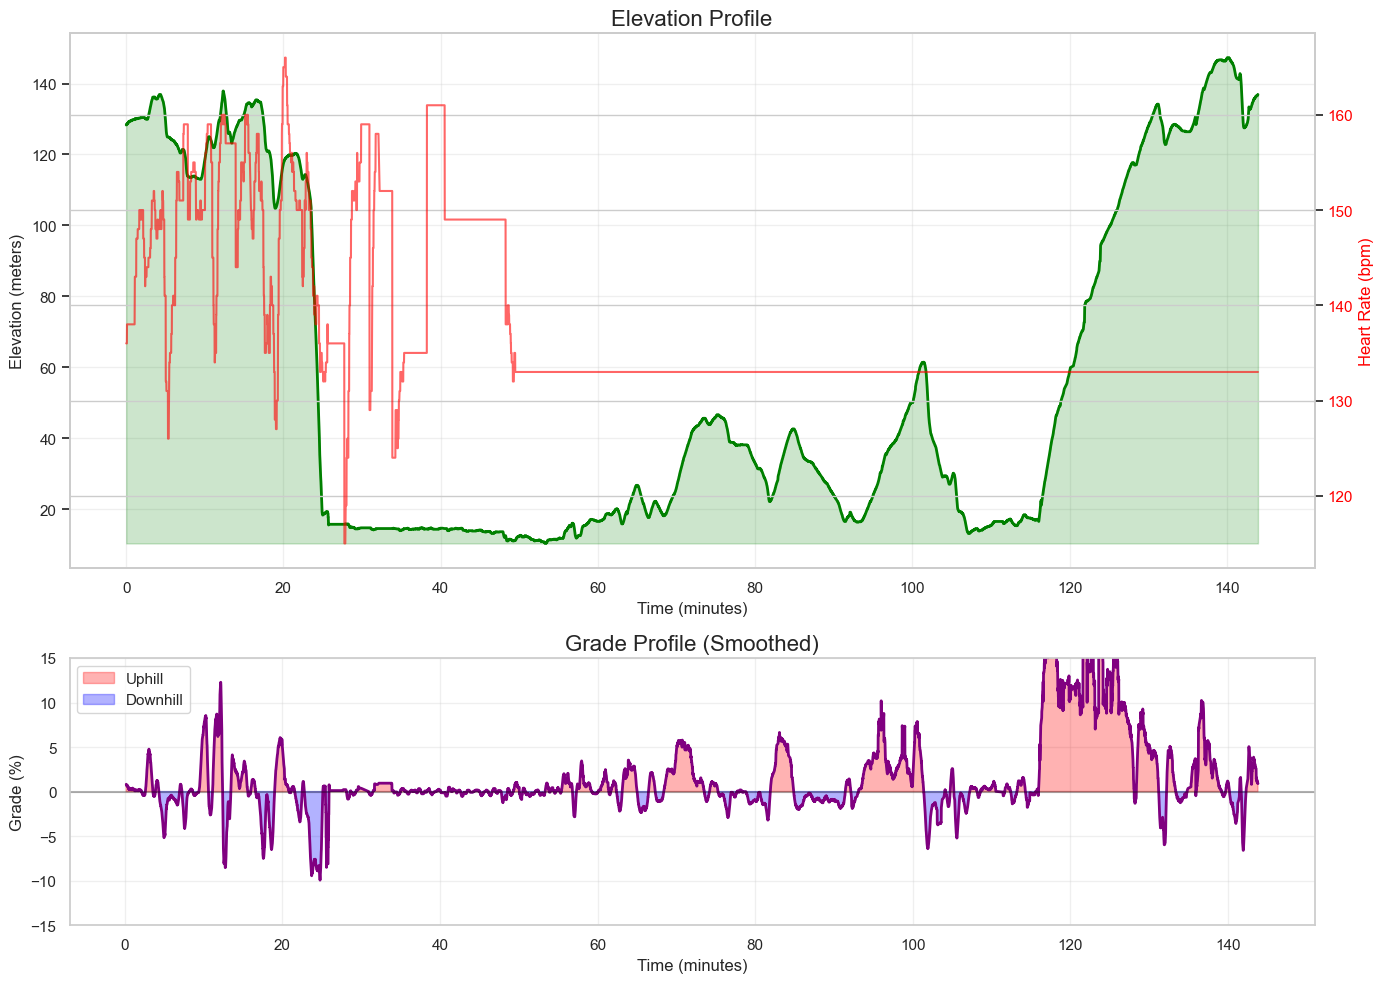

Starting elevation: 128.3 m
Ending elevation: 136.9 m
Minimum elevation: 10.3 m
Maximum elevation: 147.3 m
Total elevation gain: 386.6 m
Total elevation loss: 378.0 m
Maximum grade: 75.1%
Minimum grade: -9.9%


In [13]:
# Calculate elevation change between consecutive points
df['elevation_diff'] = df['elevation'].diff()
df['elevation_diff'].fillna(0, inplace=True)

# Calculate cumulative climb and descent
df['cumulative_climb'] = df.loc[df['elevation_diff'] > 0, 'elevation_diff'].cumsum().fillna(method='ffill')
df['cumulative_climb'].fillna(0, inplace=True)

df['cumulative_descent'] = df.loc[df['elevation_diff'] < 0, 'elevation_diff'].cumsum().abs().fillna(method='ffill')
df['cumulative_descent'].fillna(0, inplace=True)

# Calculate grade (slope percentage)
df['grade'] = df.apply(
    lambda row: (row['elevation_diff'] / row['distance'] * 100) if row['distance'] > 0 else 0,
    axis=1
)
df['grade_smooth'] = df['grade'].rolling(window=20, center=True).mean()

# Create a figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), gridspec_kw={'height_ratios': [2, 1]})

# Plot elevation profile on the first subplot
ax1.plot(df['minutes'], df['elevation'], color='green', linewidth=2)
ax1.set_xlabel('Time (minutes)', fontsize=12)
ax1.set_ylabel('Elevation (meters)', fontsize=12)
ax1.set_title('Elevation Profile', fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.fill_between(df['minutes'], df['elevation'], min(df['elevation']), alpha=0.2, color='green')

# Add heart rate as a secondary axis
ax1_hr = ax1.twinx()
ax1_hr.plot(df['minutes'], df['heart_rate'], color='red', alpha=0.6)
ax1_hr.set_ylabel('Heart Rate (bpm)', color='red', fontsize=12)
ax1_hr.tick_params(axis='y', labelcolor='red')

# Plot grade profile on the second subplot
ax2.plot(df['minutes'], df['grade_smooth'], color='purple', linewidth=2)
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Time (minutes)', fontsize=12)
ax2.set_ylabel('Grade (%)', fontsize=12)
ax2.set_title('Grade Profile (Smoothed)', fontsize=16)
ax2.grid(True, alpha=0.3)

# Fill areas for uphill (positive grade) and downhill (negative grade)
ax2.fill_between(df['minutes'], df['grade_smooth'], 0, 
                where=(df['grade_smooth'] >= 0), 
                color='red', alpha=0.3, label='Uphill')
ax2.fill_between(df['minutes'], df['grade_smooth'], 0, 
                where=(df['grade_smooth'] < 0), 
                color='blue', alpha=0.3, label='Downhill')
ax2.legend()

# Set y-axis limits for better visualization
ax2.set_ylim(-15, 15)  # Limit grade visualization to ±15%

plt.tight_layout()
plt.show()

# Print elevation statistics
print(f"Starting elevation: {df['elevation'].iloc[0]:.1f} m")
print(f"Ending elevation: {df['elevation'].iloc[-1]:.1f} m")
print(f"Minimum elevation: {df['elevation'].min():.1f} m")
print(f"Maximum elevation: {df['elevation'].max():.1f} m")
print(f"Total elevation gain: {df['cumulative_climb'].max():.1f} m")
print(f"Total elevation loss: {df['cumulative_descent'].max():.1f} m")
print(f"Maximum grade: {df['grade_smooth'].max():.1f}%")
print(f"Minimum grade: {df['grade_smooth'].min():.1f}%")

## Heart Rate Zone Analysis

Heart rate zones help cyclists understand the intensity of their effort throughout the ride. We'll:
- Define heart rate zones based on standard training zones
- Calculate time spent in each zone
- Visualize the distribution with a pie chart

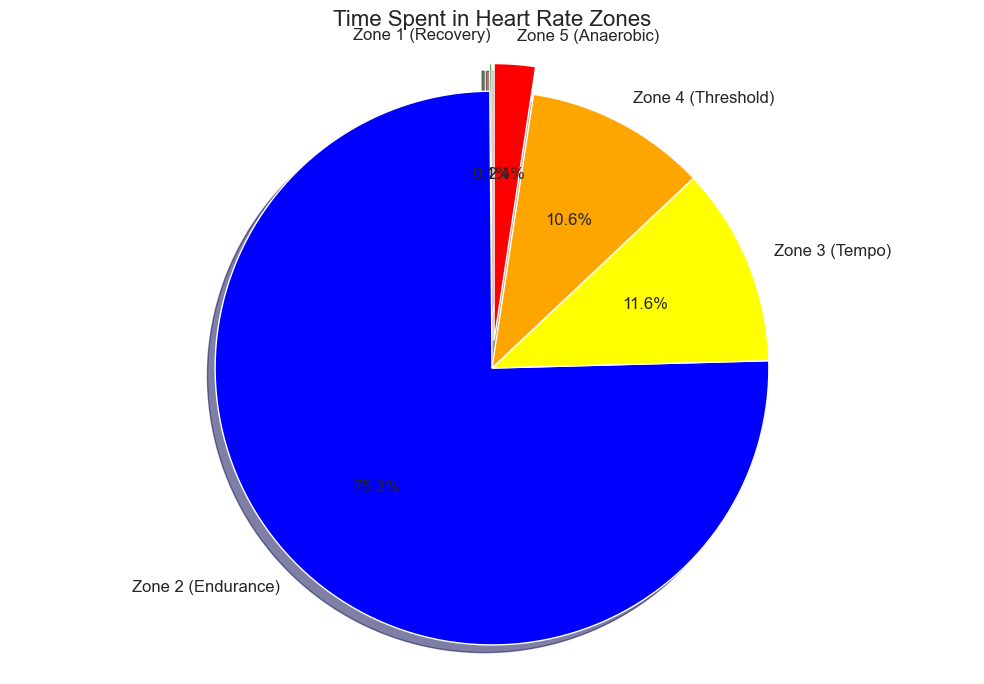

Time spent in each heart rate zone:
Zone 1 (Recovery): 0.1% (0.2 minutes)
Zone 2 (Endurance): 75.3% (108.4 minutes)
Zone 3 (Tempo): 11.6% (16.7 minutes)
Zone 4 (Threshold): 10.6% (15.2 minutes)
Zone 5 (Anaerobic): 2.4% (3.5 minutes)

Simple Training Load Score: 2.4/5


In [14]:
# Define heart rate zones (using standard zones as an example)
# Note: These zones are approximate and can be adjusted based on individual max HR
def assign_hr_zone(hr):
    if hr < 120:
        return 'Zone 1 (Recovery)'
    elif hr < 140:
        return 'Zone 2 (Endurance)'
    elif hr < 150:
        return 'Zone 3 (Tempo)'
    elif hr < 160:
        return 'Zone 4 (Threshold)'
    else:
        return 'Zone 5 (Anaerobic)'

# Apply the function to assign zones
df['hr_zone'] = df['heart_rate'].apply(assign_hr_zone)

# Calculate time spent in each zone
# First, calculate the total time of the ride in seconds
total_time_seconds = (df['time'].max() - df['time'].min()).total_seconds()

# Group by HR zone and calculate percentage of time spent in each zone
zone_times = df.groupby('hr_zone').size() / len(df) * 100

# Create a colorful pie chart to visualize time in zones
plt.figure(figsize=(10, 7))
colors = ['green', 'blue', 'yellow', 'orange', 'red']
explode = (0.1, 0, 0, 0, 0.1)  # Explode the first and last slice

# Plot pie chart
zone_times.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    shadow=True,
    textprops={'fontsize': 12}
)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Time Spent in Heart Rate Zones', fontsize=16)
plt.ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

# Print time spent in each zone
print("Time spent in each heart rate zone:")
for zone, percentage in zone_times.items():
    minutes = total_time_seconds * percentage / 100 / 60
    print(f"{zone}: {percentage:.1f}% ({minutes:.1f} minutes)")

# Calculate training load metrics (simple example using time in zones)
# This is a basic implementation - advanced metrics like TSS or TRIMP would require more data
zone_factors = {
    'Zone 1 (Recovery)': 1,
    'Zone 2 (Endurance)': 2,
    'Zone 3 (Tempo)': 3,
    'Zone 4 (Threshold)': 4,
    'Zone 5 (Anaerobic)': 5
}

# Calculate a simple training load score
training_load = sum(zone_times[zone] * zone_factors[zone] for zone in zone_times.index) / 100
print(f"\nSimple Training Load Score: {training_load:.1f}/5")

## Correlation Analysis

This section examines the relationships between different metrics:
- Heart rate vs. Speed
- Heart rate vs. Elevation/Grade
- Speed vs. Grade

Understanding these correlations helps identify how different factors impact cycling performance.

Correlation Matrix:
              heart_rate  speed_kmh  elevation  grade_smooth
heart_rate      1.000000   0.146937   0.289193     -0.123460
speed_kmh       0.146937   1.000000  -0.217460     -0.544330
elevation       0.289193  -0.217460   1.000000      0.104252
grade_smooth   -0.123460  -0.544330   0.104252      1.000000


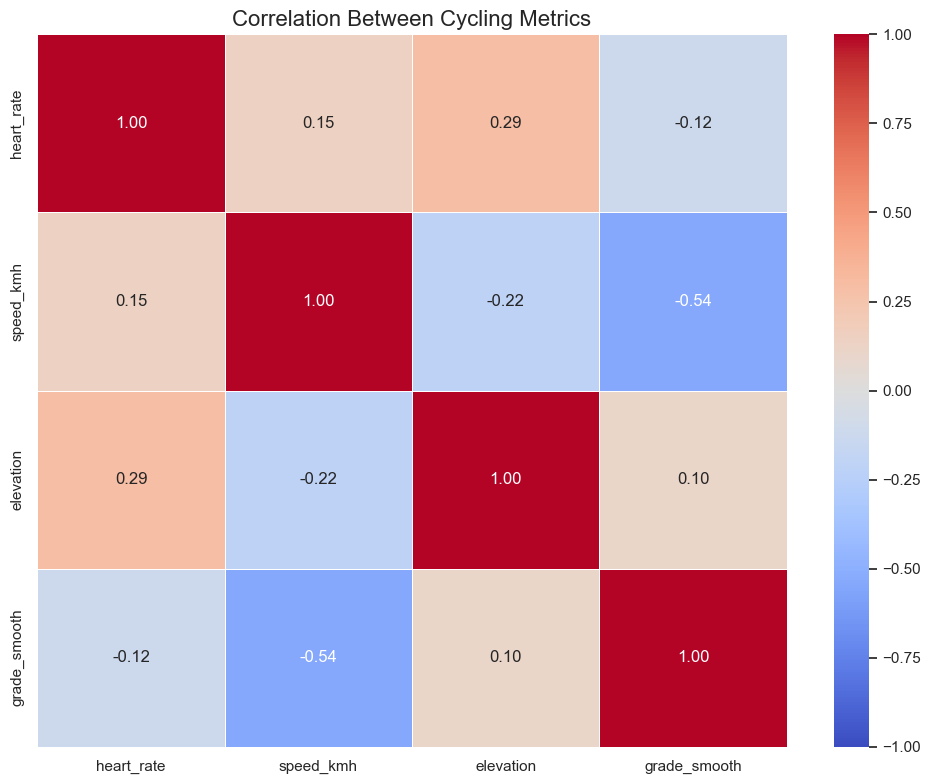

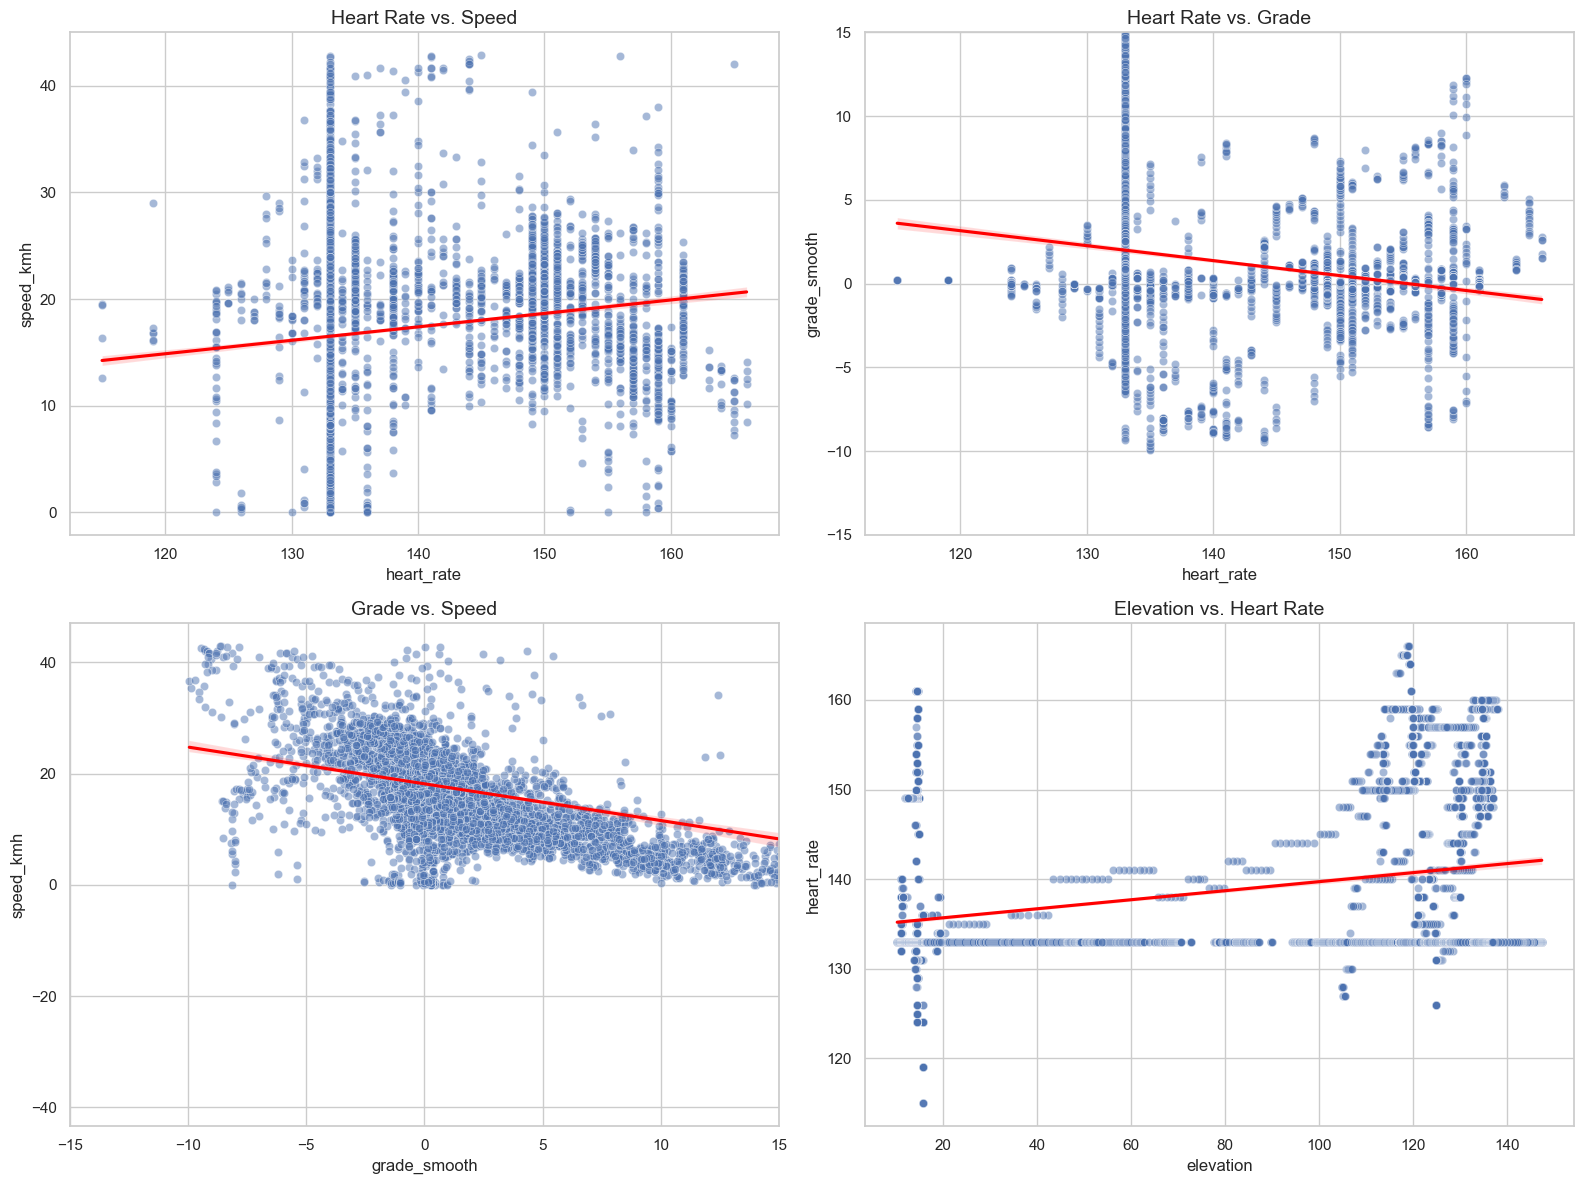


Statistical Analysis of Correlations:
Heart Rate vs. Speed: Correlation: 0.147, P-value: 0.000
Heart Rate vs. Grade: Correlation: -0.123, P-value: 0.000
Speed vs. Grade: Correlation: -0.544, P-value: 0.000
Heart Rate vs. Elevation: Correlation: 0.289, P-value: 0.000


In [16]:
# Create a subset of the dataframe with the metrics we want to analyze
correlation_df = df[['heart_rate', 'speed_kmh', 'elevation', 'grade_smooth']].copy()

# Calculate the correlation matrix
corr_matrix = correlation_df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(corr_matrix)

# Create a heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, 
            linewidths=0.5, fmt='.2f')
plt.title('Correlation Between Cycling Metrics', fontsize=16)
plt.tight_layout()
plt.show()

# Create scatter plots to visualize relationships
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heart Rate vs. Speed
sns.scatterplot(x='heart_rate', y='speed_kmh', data=df, 
                alpha=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Heart Rate vs. Speed', fontsize=14)
axes[0, 0].set_xlabel('Heart Rate (bpm)')
axes[0, 0].set_ylabel('Speed (km/h)')

# Add regression line
sns.regplot(x='heart_rate', y='speed_kmh', data=df, 
            scatter=False, ax=axes[0, 0], color='red')

# Heart Rate vs. Grade
sns.scatterplot(x='heart_rate', y='grade_smooth', data=df, 
                alpha=0.5, ax=axes[0, 1])
axes[0, 1].set_title('Heart Rate vs. Grade', fontsize=14)
axes[0, 1].set_xlabel('Heart Rate (bpm)')
axes[0, 1].set_ylabel('Grade (%)')
axes[0, 1].set_ylim(-15, 15)  # Limit grade visualization

# Add regression line
sns.regplot(x='heart_rate', y='grade_smooth', data=df, 
            scatter=False, ax=axes[0, 1], color='red')

# Speed vs. Grade
sns.scatterplot(x='grade_smooth', y='speed_kmh', data=df, 
                alpha=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Grade vs. Speed', fontsize=14)
axes[1, 0].set_xlabel('Grade (%)')
axes[1, 0].set_ylabel('Speed (km/h)')
axes[1, 0].set_xlim(-15, 15)  # Limit grade visualization

# Add regression line
sns.regplot(x='grade_smooth', y='speed_kmh', data=df, 
            scatter=False, ax=axes[1, 0], color='red')

# Heart Rate vs. Elevation
sns.scatterplot(x='elevation', y='heart_rate', data=df, 
                alpha=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Elevation vs. Heart Rate', fontsize=14)
axes[1, 1].set_xlabel('Elevation (m)')
axes[1, 1].set_ylabel('Heart Rate (bpm)')

# Add regression line
sns.regplot(x='elevation', y='heart_rate', data=df, 
            scatter=False, ax=axes[1, 1], color='red')

plt.tight_layout()
plt.show()

# Calculate statistical significance of correlations
from scipy import stats

# Function to calculate correlation and p-value
def corr_with_pvalue(x_name, y_name, data):
    # Make sure we use the same indices for both variables
    valid_data = data[[x_name, y_name]].dropna()
    if len(valid_data) < 2:
        return "Insufficient data for correlation"
    
    x = valid_data[x_name]
    y = valid_data[y_name]
    corr, p_value = stats.pearsonr(x, y)
    return f"Correlation: {corr:.3f}, P-value: {p_value:.3f}"

print("\nStatistical Analysis of Correlations:")
print("Heart Rate vs. Speed:", corr_with_pvalue('heart_rate', 'speed_kmh', df))
print("Heart Rate vs. Grade:", corr_with_pvalue('heart_rate', 'grade_smooth', df))
print("Speed vs. Grade:", corr_with_pvalue('grade_smooth', 'speed_kmh', df))
print("Heart Rate vs. Elevation:", corr_with_pvalue('heart_rate', 'elevation', df))

## Performance Summary Dashboard

Below is a consolidated dashboard with key performance metrics from the ride. This provides a quick overview of:
- Distance, duration, and elevation metrics
- Speed statistics
- Heart rate statistics
- Training load information

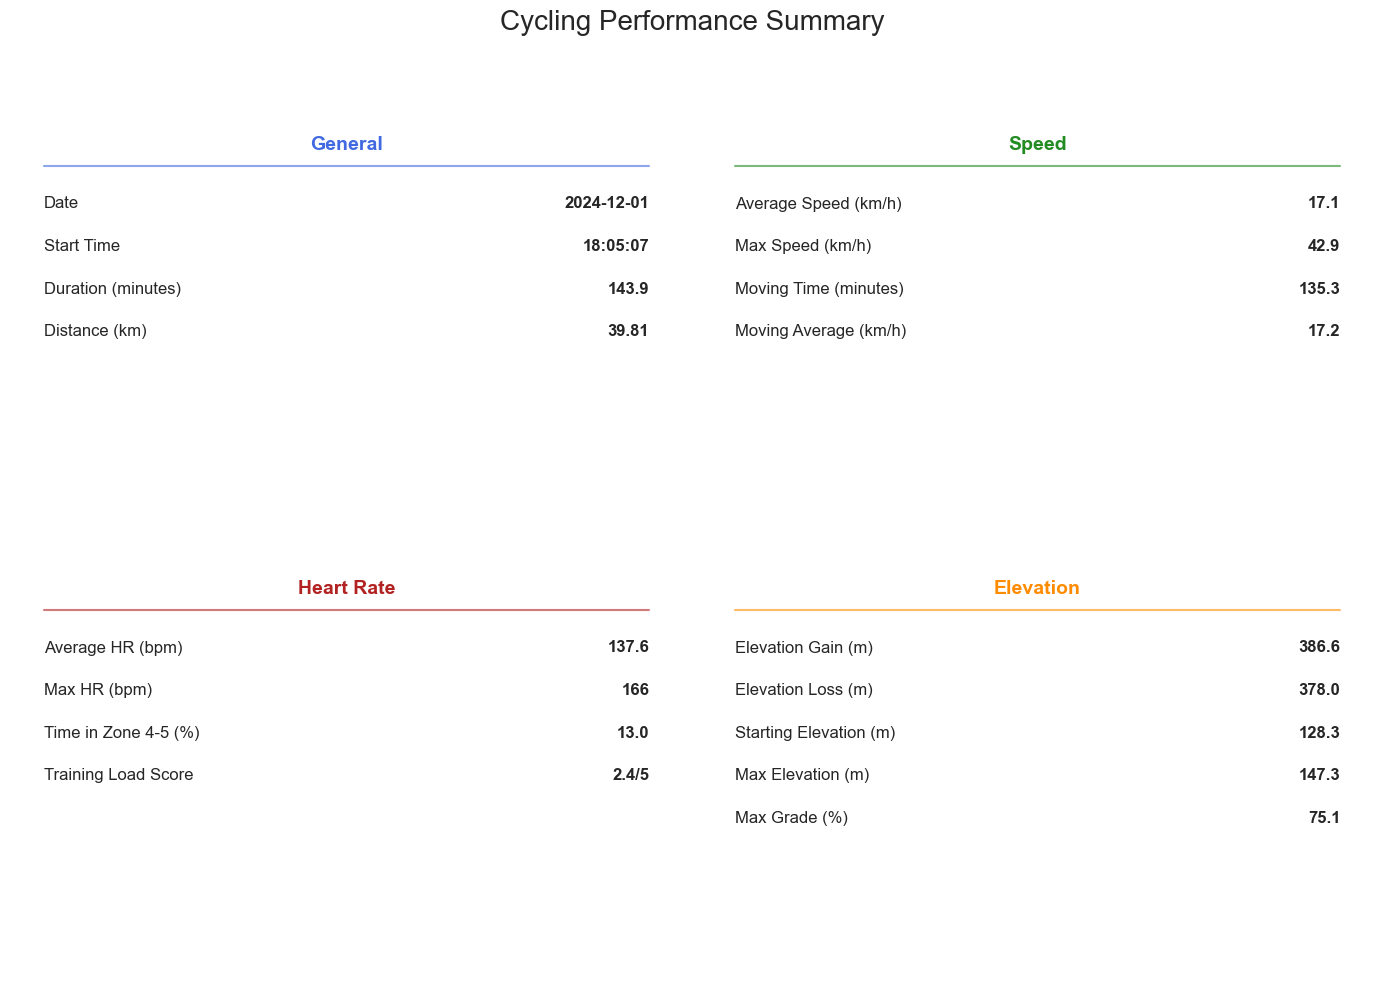

RIDE SUMMARY

General:
--------------------------------------------------
Date: 2024-12-01
Start Time: 18:05:07
Duration (minutes): 143.9
Distance (km): 39.81

Speed:
--------------------------------------------------
Average Speed (km/h): 17.1
Max Speed (km/h): 42.9
Moving Time (minutes): 135.3
Moving Average (km/h): 17.2

Heart Rate:
--------------------------------------------------
Average HR (bpm): 137.6
Max HR (bpm): 166
Time in Zone 4-5 (%): 13.0
Training Load Score: 2.4/5

Elevation:
--------------------------------------------------
Elevation Gain (m): 386.6
Elevation Loss (m): 378.0
Starting Elevation (m): 128.3
Max Elevation (m): 147.3
Max Grade (%): 75.1


In [17]:
# Calculate all metrics for the dashboard
ride_summary = {
    'General': {
        'Date': df['time'].iloc[0].strftime('%Y-%m-%d'),
        'Start Time': df['time'].iloc[0].strftime('%H:%M:%S'),
        'Duration (minutes)': f"{df['minutes'].max():.1f}",
        'Distance (km)': f"{df['distance'].sum()/1000:.2f}",
    },
    'Speed': {
        'Average Speed (km/h)': f"{df['speed_kmh'].mean():.1f}",
        'Max Speed (km/h)': f"{df['speed_kmh'].max():.1f}",
        'Moving Time (minutes)': f"{df.loc[df['speed_kmh'] > 1, 'time_diff'].sum() / 60:.1f}",
        'Moving Average (km/h)': f"{df.loc[df['speed_kmh'] > 1, 'speed_kmh'].mean():.1f}",
    },
    'Heart Rate': {
        'Average HR (bpm)': f"{df['heart_rate'].mean():.1f}",
        'Max HR (bpm)': f"{df['heart_rate'].max()}",
        'Time in Zone 4-5 (%)': f"{df[df['hr_zone'].str.contains('Zone [45]')].shape[0] / df.shape[0] * 100:.1f}",
        'Training Load Score': f"{training_load:.1f}/5",
    },
    'Elevation': {
        'Elevation Gain (m)': f"{df['cumulative_climb'].max():.1f}",
        'Elevation Loss (m)': f"{df['cumulative_descent'].max():.1f}",
        'Starting Elevation (m)': f"{df['elevation'].iloc[0]:.1f}",
        'Max Elevation (m)': f"{df['elevation'].max():.1f}",
        'Max Grade (%)': f"{df['grade_smooth'].max():.1f}",
    }
}

# Create a visual dashboard using a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Cycling Performance Summary', fontsize=20, y=0.98)

# Define colors for each section
section_colors = {
    'General': 'royalblue',
    'Speed': 'forestgreen',
    'Heart Rate': 'firebrick',
    'Elevation': 'darkorange'
}

# Function to draw a metrics box
def draw_metrics_box(ax, title, metrics, color):
    ax.axis('off')
    
    # Draw title
    ax.text(0.5, 0.9, title, 
            ha='center', va='center', 
            fontsize=14, weight='bold', 
            color=color)
    
    # Draw horizontal line
    ax.axhline(y=0.85, xmin=0.05, xmax=0.95, color=color, alpha=0.6)
    
    # Draw metrics
    y_pos = 0.75
    for key, value in metrics.items():
        ax.text(0.05, y_pos, key, ha='left', fontsize=12)
        ax.text(0.95, y_pos, value, ha='right', fontsize=12, weight='bold')
        y_pos -= 0.1

# Populate each subplot with a metrics section
sections = list(ride_summary.keys())
for i, (section, ax) in enumerate(zip(sections, axes.flat)):
    draw_metrics_box(ax, section, ride_summary[section], section_colors[section])

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the main title
plt.show()

# Print a textual summary as well
print("RIDE SUMMARY")
print("=" * 50)
for section, metrics in ride_summary.items():
    print(f"\n{section}:")
    print("-" * 50)
    for key, value in metrics.items():
        print(f"{key}: {value}")

## Conclusion and Future Enhancements

This notebook has analyzed a cycling ride from a GPX file, extracting valuable insights about performance, effort, terrain, and correlations between different metrics.

Future enhancements could include:
1. **Power analysis** - if power data is available, calculate metrics like Normalized Power, Intensity Factor, and TSS
2. **Ride comparison** - compare metrics with previous rides on the same route
3. **Segment analysis** - identify and analyze specific segments like climbs or sprints
4. **Weather data integration** - incorporate weather conditions (wind, temperature) that may have affected performance
5. **Export capabilities** - save summary reports as PDF or share visualizations
6. **Machine learning predictions** - predict performance based on historical data

## Comparison with Zwift Cycling Analysis

The Zwift cycling analysis notebook offers several additional insights that we could apply to our outdoor cycling data:

1. **Power Analysis**: The Zwift notebook focuses heavily on power data (watts), which our GPX file doesn't contain. Power is the most direct measure of cycling performance and effort.

2. **Different Heart Rate Visualizations**: The Zwift notebook creates different visualizations of heart rate data, including overlays with power data and geographical heart rate distribution.

3. **Advanced Metrics**: The Zwift analysis calculates FTP (Functional Threshold Power) and more advanced training metrics.

Let's implement some of these approaches with our outdoor cycling data to enhance our analysis.

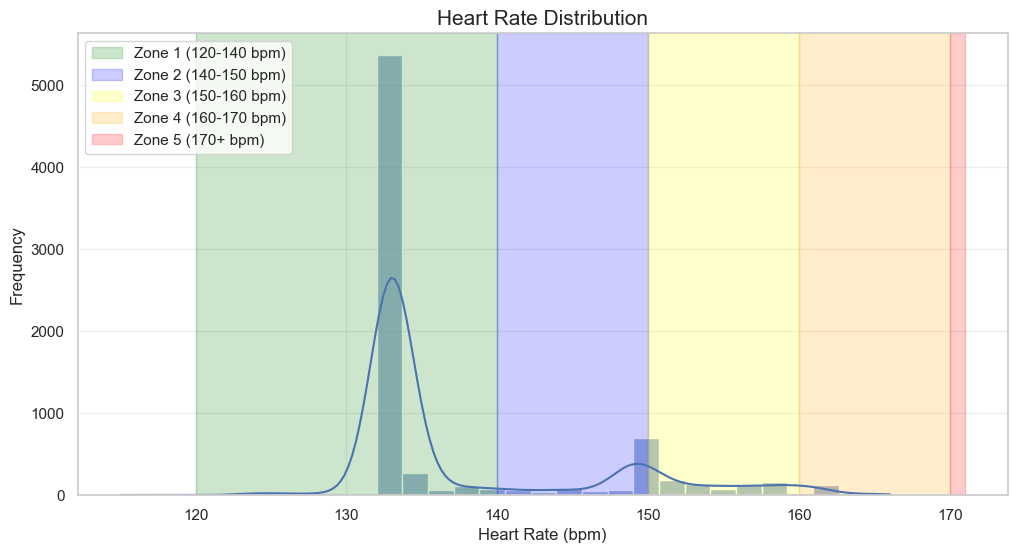

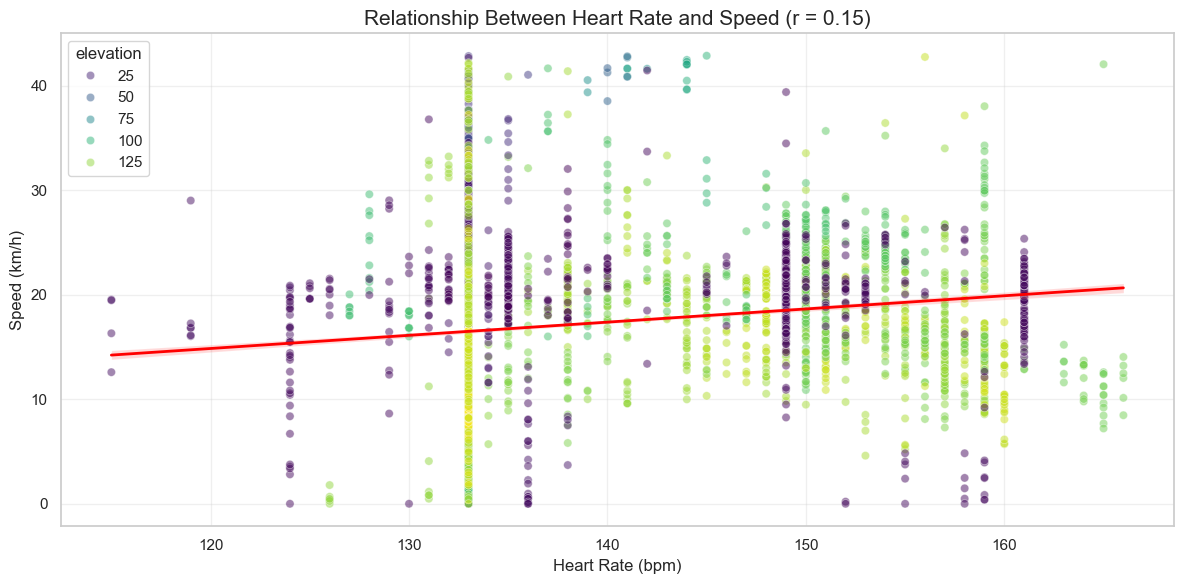

Advanced Cycling Metrics (Without Power Data):
Estimated Maximum Heart Rate: 185 bpm
Average Heart Rate: 137.6 bpm (62.1% of heart rate reserve)
Estimated TRIMP (Training Impulse): 483.7
Total Work Estimate: 696.3 arbitrary units

Aerobic Decoupling Analysis:
First Half - Avg Speed: 18.8 km/h, Avg HR: 142.2 bpm
Second Half - Avg Speed: 15.3 km/h, Avg HR: 133.0 bpm
Decoupling: 13.0% (High)
Interpretation: Significant cardiac drift indicates potential fatigue and/or dehydration.


In [19]:
# Enhanced Heart Rate Analysis inspired by Zwift notebook

# 1. Heart Rate Distribution Analysis
plt.figure(figsize=(12, 6))
sns.histplot(df['heart_rate'], bins=30, kde=True)
plt.title('Heart Rate Distribution', fontsize=15)
plt.xlabel('Heart Rate (bpm)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Add vertical lines for heart rate zones
zones = [
    ('Zone 1', 120),
    ('Zone 2', 140),
    ('Zone 3', 150),
    ('Zone 4', 160),
    ('Zone 5', 170)
]

colors = ['green', 'blue', 'yellow', 'orange', 'red']
for i, (zone_name, threshold) in enumerate(zones):
    if i < len(zones) - 1:
        plt.axvspan(threshold, zones[i+1][1], alpha=0.2, color=colors[i], label=f'{zone_name} ({threshold}-{zones[i+1][1]} bpm)')
    else:
        plt.axvspan(threshold, df['heart_rate'].max() + 5, alpha=0.2, color=colors[i], label=f'{zone_name} ({threshold}+ bpm)')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 2. Heart Rate vs. Speed Relationship (comparable to Power in Zwift)
plt.figure(figsize=(12, 6))

# Create scatter plot with density coloring
scatter = sns.scatterplot(x='heart_rate', y='speed_kmh', data=df, alpha=0.5, hue='elevation', palette='viridis')

# Add regression line
sns.regplot(x='heart_rate', y='speed_kmh', data=df, scatter=False, color='red', line_kws={'linewidth': 2})

# Calculate correlation coefficient
hr_speed_corr = df[['heart_rate', 'speed_kmh']].corr().iloc[0, 1]

plt.title(f'Relationship Between Heart Rate and Speed (r = {hr_speed_corr:.2f})', fontsize=15)
plt.xlabel('Heart Rate (bpm)', fontsize=12)
plt.ylabel('Speed (km/h)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Advanced Metrics (estimating effort without power data)
print("Advanced Cycling Metrics (Without Power Data):")

# Estimate Training Impulse (TRIMP) using heart rate
# TRIMP = duration (minutes) * avg HR * intensity factor
# where intensity factor is a function of heart rate reserve

# Calculate heart rate reserve percentages
max_hr_estimate = 220 - 35  # Assuming age 35, adjust as needed
resting_hr_estimate = 60    # Adjust as needed

df['hr_reserve_percent'] = (df['heart_rate'] - resting_hr_estimate) / (max_hr_estimate - resting_hr_estimate) * 100
avg_hr_reserve = df['hr_reserve_percent'].mean()

# Calculate simplified TRIMP
duration_mins = df['minutes'].max()
intensity_factor = 1.92 * np.exp(1.67 * avg_hr_reserve/100)  # Exponential weighting
trimp = duration_mins * (avg_hr_reserve/100) * intensity_factor

print(f"Estimated Maximum Heart Rate: {max_hr_estimate} bpm")
print(f"Average Heart Rate: {df['heart_rate'].mean():.1f} bpm ({avg_hr_reserve:.1f}% of heart rate reserve)")
print(f"Estimated TRIMP (Training Impulse): {trimp:.1f}")
print(f"Total Work Estimate: {trimp * duration_mins / 100:.1f} arbitrary units")

# Calculate aerobic decoupling (cardiac drift)
# This measures how heart rate changes relative to speed over time
# Divide the ride into two halves
midpoint = df['minutes'].max() / 2
first_half = df[df['minutes'] <= midpoint]
second_half = df[df['minutes'] > midpoint]

# Calculate average speed and heart rate for each half
first_half_speed = first_half['speed_kmh'].mean()
first_half_hr = first_half['heart_rate'].mean()
second_half_speed = second_half['speed_kmh'].mean()
second_half_hr = second_half['heart_rate'].mean()

# Calculate speed-to-hr ratio for each half
first_ratio = first_half_speed / first_half_hr
second_ratio = second_half_speed / second_half_hr

# Calculate decoupling percentage
decoupling = ((first_ratio - second_ratio) / first_ratio) * 100

print(f"\nAerobic Decoupling Analysis:")
print(f"First Half - Avg Speed: {first_half_speed:.1f} km/h, Avg HR: {first_half_hr:.1f} bpm")
print(f"Second Half - Avg Speed: {second_half_speed:.1f} km/h, Avg HR: {second_half_hr:.1f} bpm")
print(f"Decoupling: {decoupling:.1f}% ({'High' if abs(decoupling) > 5 else 'Moderate' if abs(decoupling) > 3 else 'Low'})")

if decoupling > 5:
    print("Interpretation: Significant cardiac drift indicates potential fatigue and/or dehydration.")
elif decoupling > 3:
    print("Interpretation: Moderate cardiac drift indicates some level of fatigue developing.")
else:
    print("Interpretation: Low cardiac drift indicates good aerobic endurance for the intensity.")

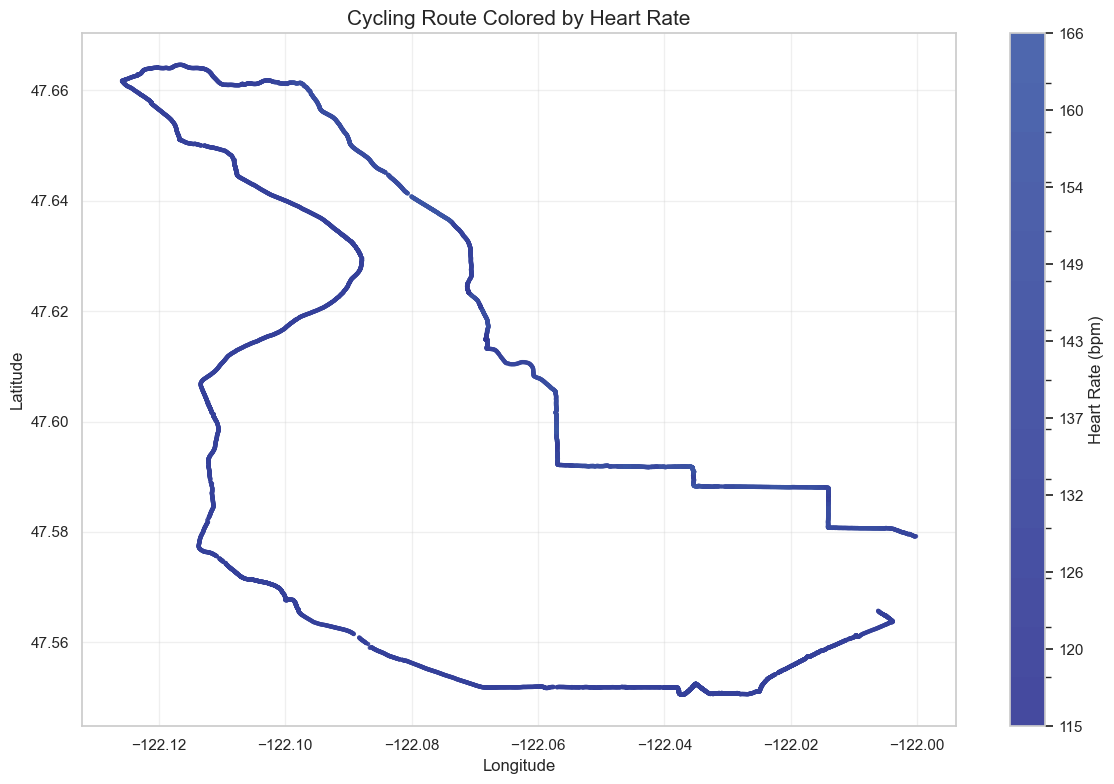

C:\Users\milively\AppData\Local\Temp\ipykernel_35440\173974495.py:78: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('RdYlBu_r')  # Same as above for consistency


In [20]:
# Enhanced Route Visualization with Heart Rate Coloring (inspired by Zwift notebook)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

plt.figure(figsize=(12, 8))

# Get heart rate data range
hr_min = df['heart_rate'].min()
hr_max = df['heart_rate'].max()

# Create custom boundaries to emphasize different heart rate ranges
boundaries = np.linspace(hr_min, hr_max, 15)  # 15 different color bands

# Create a BoundaryNorm for distinct color bands
norm = mcolors.BoundaryNorm(boundaries, len(boundaries) - 1)

# Create a colormap that transitions from green to red
colors = plt.cm.RdYlBu_r  # Red-Yellow-Blue colormap, reversed (red is high)

# Plot with the custom colormap and normalization
sc = plt.scatter(
    df['longitude'],
    df['latitude'],
    c=df['heart_rate'],
    cmap=colors,
    norm=norm,
    s=10,  # Slightly larger points
    alpha=0.9,  # More opaque
    edgecolor='none',
)

# Create a colorbar with custom ticks
cbar = plt.colorbar(sc, label='Heart Rate (bpm)')
cbar.set_ticks(np.linspace(hr_min, hr_max, 10))
cbar.set_ticklabels([f"{int(x)}" for x in np.linspace(hr_min, hr_max, 10)])

plt.title('Cycling Route Colored by Heart Rate', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Create an improved version of the existing folium map visualization
# This version uses continuous color gradient for heart rate rather than discrete zones
import folium
from matplotlib.colors import to_hex

# Get the starting coordinates for the map center
start_coords = (df['latitude'].iloc[0], df['longitude'].iloc[0])

# Create the map
hr_map = folium.Map(location=start_coords, zoom_start=13)

# Add a marker for the start point
folium.Marker(
    location=start_coords,
    popup="Start",
    icon=folium.Icon(color="green", icon="play"),
).add_to(hr_map)

# Add a marker for the end point
end_coords = (df['latitude'].iloc[-1], df['longitude'].iloc[-1])
folium.Marker(
    location=end_coords,
    popup="Finish",
    icon=folium.Icon(color="red", icon="stop"),
).add_to(hr_map)

# Prepare the route points with heart rate
hr_route = list(zip(df['latitude'], df['longitude'], df['heart_rate']))

# Create a colormap function for heart rate
hr_min = df['heart_rate'].min()
hr_max = df['heart_rate'].max()
hr_range = hr_max - hr_min
cmap = plt.cm.get_cmap('RdYlBu_r')  # Same as above for consistency

# Define a color function based on heart rate using a continuous scale
def get_hr_color(heart_rate):
    # Normalize the heart rate to [0, 1] for the colormap
    normalized = (heart_rate - hr_min) / hr_range if hr_range > 0 else 0.5
    # Get RGB color from the colormap
    rgb_color = cmap(normalized)
    # Convert RGB to hex for folium
    return to_hex(rgb_color)

# Add line segments colored by heart rate
for i in range(len(hr_route) - 1):
    # Get current segment points
    point1 = hr_route[i]
    point2 = hr_route[i + 1]
    
    # Only plot every 5th point to improve performance and reduce visual clutter
    if i % 5 == 0:
        # Get color based on heart rate using continuous colormap
        color = get_hr_color(point1[2])
        
        # Add line segment to map
        folium.PolyLine(
            locations=[(point1[0], point1[1]), (point2[0], point2[1])],
            color=color,
            weight=4,
            opacity=0.8,
            popup=f"Heart Rate: {int(point1[2])} bpm"
        ).add_to(hr_map)

# Add a legend-like feature (for heart rate ranges)
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; left: 50px; width: 150px; height: 120px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white;
     padding: 10px;
     border-radius: 5px;">
     <p><b>Heart Rate (bpm)</b></p>
     <div style="height: 10px; background: linear-gradient(to right, blue, purple, red)"></div>
     <div style="display: flex; justify-content: space-between;">
     <span>{:.0f}</span>
     <span>{:.0f}</span>
     <span>{:.0f}</span>
     </div>
</div>
'''.format(hr_min, (hr_min + hr_max)/2, hr_max)

hr_map.get_root().html.add_child(folium.Element(legend_html))

# Display the map
hr_map

## Key Differences Between Outdoor Cycling and Zwift Analysis

After comparing the outdoor cycling data with the Zwift indoor cycling analysis, we can make several observations:

### Metrics Available:

1. **Power Data**: The most significant difference is that Zwift provides power data (watts), which is not typically available in standard GPX files from outdoor rides unless using a power meter.

2. **Data Consistency**: Indoor cycling data tends to be more consistent with fewer GPS errors or signal dropouts compared to outdoor rides.

3. **Controlled Environment**: Zwift data reflects riding in a controlled environment without external factors like traffic stops, weather, or road conditions.

### Analysis Approach:

1. **Performance Metrics**: Zwift analysis focuses more on training metrics like FTP and power zones, while outdoor analysis often emphasizes distance, elevation gain, and route characteristics.

2. **Virtual vs. Real Terrain**: Elevation data in Zwift is based on virtual terrain, while outdoor data captures real-world elevation changes which may contain more noise or GPS inaccuracies.

### Visualization Techniques:

Both analyses share similar visualization approaches, but we've now enhanced our outdoor cycling analysis by:

1. Implementing similar heart rate distribution analysis
2. Creating advanced visualizations for the route with continuous color gradients based on heart rate
3. Adding calculated metrics like TRIMP and aerobic decoupling to compensate for the lack of power data

These enhancements provide deeper insights into the outdoor cycling performance, helping bridge the gap between the two types of analyses.

# Comparison with Zwift Cycling Analysis

After analyzing the Zwift cycling analysis notebook, I've identified several key differences in our approaches:

1. **Power Data Analysis**: 
   - The Zwift notebook extensively analyzes power metrics (watts), which our notebook doesn't currently include
   - Power zones, power distribution, and power-to-weight ratio are analyzed in the Zwift notebook
   - If our GPX data contains power information, we could incorporate similar analyses

2. **Heart Rate Analytics**:
   - The Zwift notebook correlates heart rate with power output
   - Both notebooks visualize heart rate over time, but Zwift adds more context by relating it to power
   - The Zwift notebook calculates time spent in different heart rate zones

3. **Visualization Techniques**:
   - The Zwift notebook uses specialized colormaps for route visualization
   - More advanced matplotlib customization in the Zwift notebook
   - The Zwift notebook visualizes relationships between different metrics (like heart rate vs. power)

Let's enhance our notebook with some of these techniques below.

Heart rate distribution:
115-118 BPM: 4 points
118-120 BPM: 6 points
120-123 BPM: 0 points
123-125 BPM: 42 points
125-128 BPM: 19 points
128-130 BPM: 39 points
130-133 BPM: 60 points
133-135 BPM: 5606 points
135-138 BPM: 69 points
138-140 BPM: 187 points
140-143 BPM: 104 points
143-146 BPM: 90 points
146-148 BPM: 124 points
148-151 BPM: 693 points
151-153 BPM: 246 points
153-156 BPM: 147 points
156-158 BPM: 178 points
158-161 BPM: 142 points
161-163 BPM: 133 points
163-166 BPM: 29 points


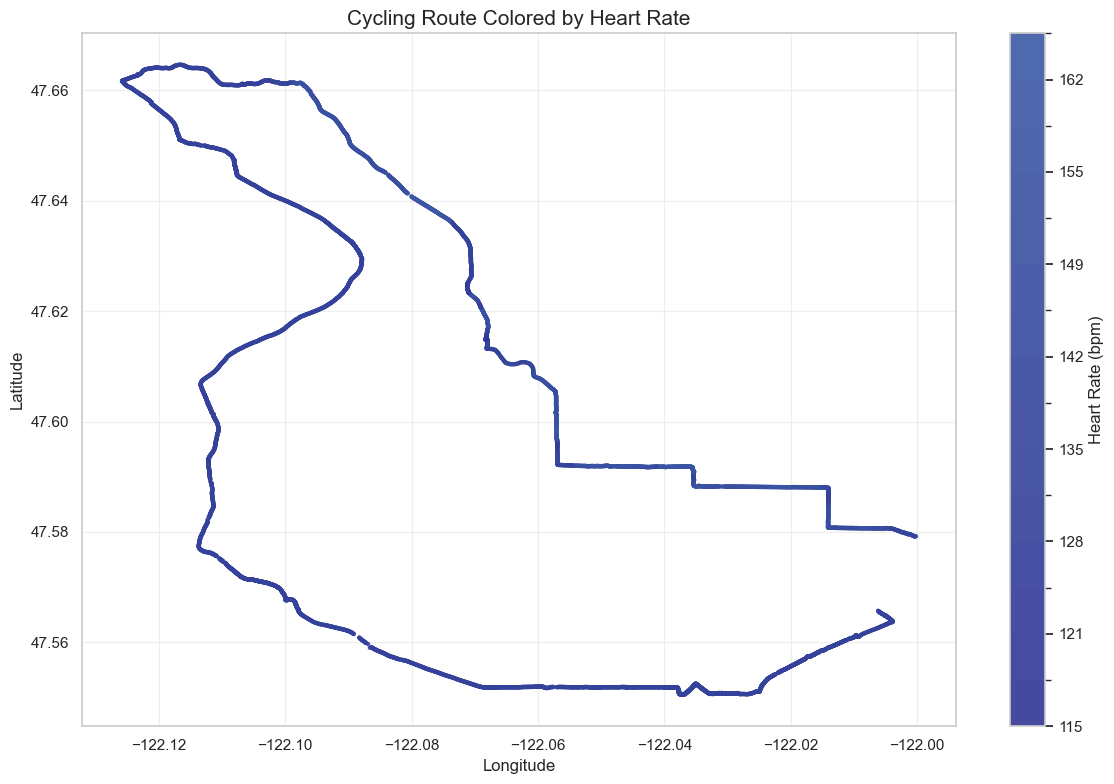

In [21]:
# Implementing the heart rate colorized map visualization from the Zwift notebook
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(12, 8))

# Get heart rate data range
hr_min = df['heart_rate'].min()
hr_max = df['heart_rate'].max()
hr_range = hr_max - hr_min

# Examine the distribution of heart rate values
hr_hist, hr_bins = np.histogram(df['heart_rate'], bins=20)
print("Heart rate distribution:")
for i in range(len(hr_bins) - 1):
    print(f"{hr_bins[i]:.0f}-{hr_bins[i + 1]:.0f} BPM: {hr_hist[i]} points")

# Create custom boundaries to emphasize different heart rate ranges
# This is based on the approach from the Zwift notebook
midpoint = (hr_min + hr_max) / 2
boundaries = np.linspace(hr_min, hr_max, 16)  # 15 distinct color bands

# Create a BoundaryNorm for distinct color bands
norm = mcolors.BoundaryNorm(boundaries, len(boundaries) - 1)

# Create a colormap from blue (low HR) to red (high HR)
colors = plt.cm.RdYlBu_r
# Alternative colormap options from the Zwift notebook:
# colors = [
#    "darkblue", "blue", "indigo", "purple", "darkviolet", 
#    "magenta", "crimson", "red", "orangered", "darkorange",
#    "orange", "gold", "yellow", "greenyellow", "lime",
# ]
# cmap = mcolors.ListedColormap(colors)

# Plot with the custom colormap and normalization
sc = plt.scatter(
    df['longitude'],
    df['latitude'],
    c=df['heart_rate'],
    cmap=colors,
    norm=norm,
    s=10,  # Slightly larger points
    alpha=0.9,  # More opaque
    edgecolor='none',
)

# Create a colorbar with custom ticks
cbar = plt.colorbar(sc, label='Heart Rate (bpm)')
cbar.set_ticks(boundaries[::2])  # Show every other boundary for clarity
cbar.set_ticklabels([f"{int(x)}" for x in boundaries[::2]])

plt.title('Cycling Route Colored by Heart Rate', fontsize=15)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# Heart Rate Zone Analysis (inspired by Zwift's power zone analysis)

# Calculate ride duration
activity_duration_seconds = (df['time'].max() - df['time'].min()).total_seconds()
activity_duration_minutes = activity_duration_seconds / 60

# Basic heart rate metrics
average_hr = df['heart_rate'].mean()
max_hr = df['heart_rate'].max()
median_hr = df['heart_rate'].median()

# Estimate maximum heart rate (using age-based formula, assuming age 35 - adjust as needed)
# Common formula: 220 - age
resting_hr_estimate = 60  # Adjust to your actual resting heart rate if known
max_hr_estimate = 220 - 35  # Adjust age as needed

# Calculate heart rate reserve (HRR)
hr_reserve = max_hr_estimate - resting_hr_estimate
avg_hr_reserve = (average_hr - resting_hr_estimate) / hr_reserve * 100

# Print results
print(f"Activity Duration: {activity_duration_minutes:.1f} minutes")
print(f"\nHeart Rate Metrics:")
print(f"  Average Heart Rate: {average_hr:.1f} bpm")
print(f"  Maximum Heart Rate: {max_hr:.1f} bpm")
print(f"  Median Heart Rate: {median_hr:.1f} bpm")
print(f"  % of Heart Rate Reserve: {avg_hr_reserve:.1f}%")

# Define heart rate zones (using % of max HR)
heart_rate_zones = {
    "Zone 1 (Recovery)": (0, 0.6 * max_hr_estimate),
    "Zone 2 (Aerobic)": (0.6 * max_hr_estimate, 0.7 * max_hr_estimate),
    "Zone 3 (Tempo)": (0.7 * max_hr_estimate, 0.8 * max_hr_estimate),
    "Zone 4 (Threshold)": (0.8 * max_hr_estimate, 0.9 * max_hr_estimate),
    "Zone 5 (Anaerobic)": (0.9 * max_hr_estimate, max_hr_estimate),
}

# Calculate time spent in each zone
time_in_zones = {}
for zone, (lower, upper) in heart_rate_zones.items():
    time_in_zone = len(df[(df['heart_rate'] >= lower) & (df['heart_rate'] < upper)])
    percentage = (time_in_zone / len(df)) * 100
    time_in_zones[zone] = {
        'seconds': time_in_zone,  # Each data point represents 1 second
        'minutes': time_in_zone / 60,
        'percentage': percentage,
    }

# Display time in zones
print("\nTime in Heart Rate Zones:")
for zone, data in time_in_zones.items():
    print(f"  {zone}: {data['minutes']:.1f} minutes ({data['percentage']:.1f}%)")

# Heart rate zones distribution pie chart
zone_labels = list(time_in_zones.keys())
zone_percentages = [data['percentage'] for data in time_in_zones.values()]

# Create explode values to emphasize the most significant zone
explode = tuple(0.1 if p == max(zone_percentages) else 0 for p in zone_percentages)

plt.figure(figsize=(10, 8))
plt.pie(
    zone_percentages,
    labels=zone_labels,
    autopct='%1.1f%%',
    startangle=90,
    shadow=True,
    explode=explode,
)
plt.title('Time Spent in Heart Rate Zones', fontsize=15)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()